In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# Loading the data

In [63]:
# Data directory for NSL-KDD dataset
data_path = "/content/sample_data/"

In [64]:
# Load the data into pandas dataframes
train_df = pd.read_csv(data_path + "UNSW_NB15_train.csv")
test_df = pd.read_csv(data_path + "UNSW_NB15_test.csv")

# Print the first 5 rows of the train data
train_df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,Normal,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,Normal,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,Normal,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,Normal,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,Normal,0


In [65]:
print("Shape of the training data", train_df.shape)
print("Number of data points", train_df.shape[0])
print("Number of features",train_df.shape[1])

Shape of the training data (175341, 44)
Number of data points 175341
Number of features 44


In [66]:
print("Shape of the testing data", test_df.shape)
print("Number of data points", test_df.shape[0])
print("Number of features",test_df.shape[1])

Shape of the testing data (82332, 44)
Number of data points 82332
Number of features 44


# Data exploration

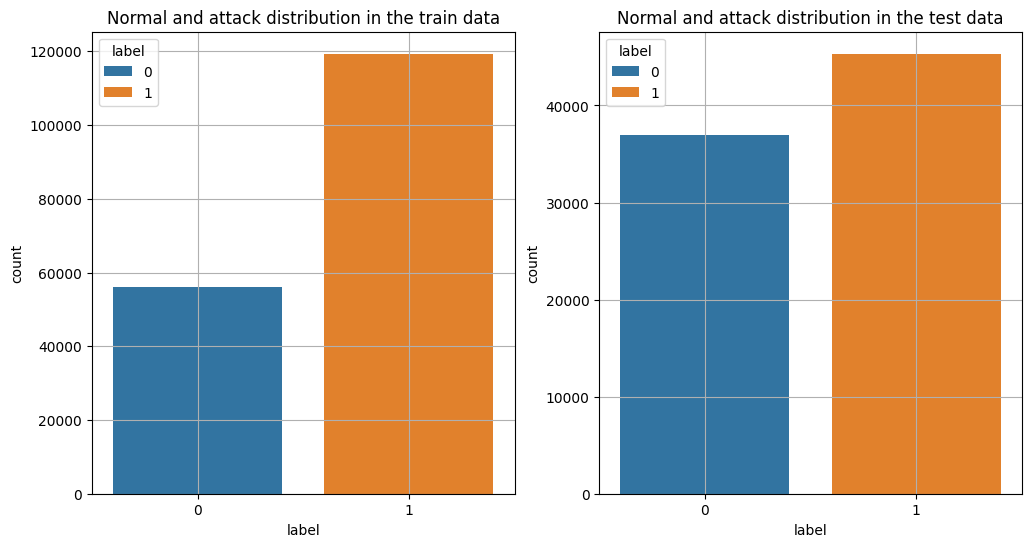

In [67]:
# Plot the distributions of normal class 0 and attack class 1
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.countplot(x ='label' , data =train_df, hue='label')
plt.title("Normal and attack distribution in the train data")
plt.grid()
plt.subplot(1,2,2)
sns.countplot(x ='label' , data=test_df, hue ='label')
plt.title("Normal and attack distribution in the test data")
plt.grid()
plt.show()

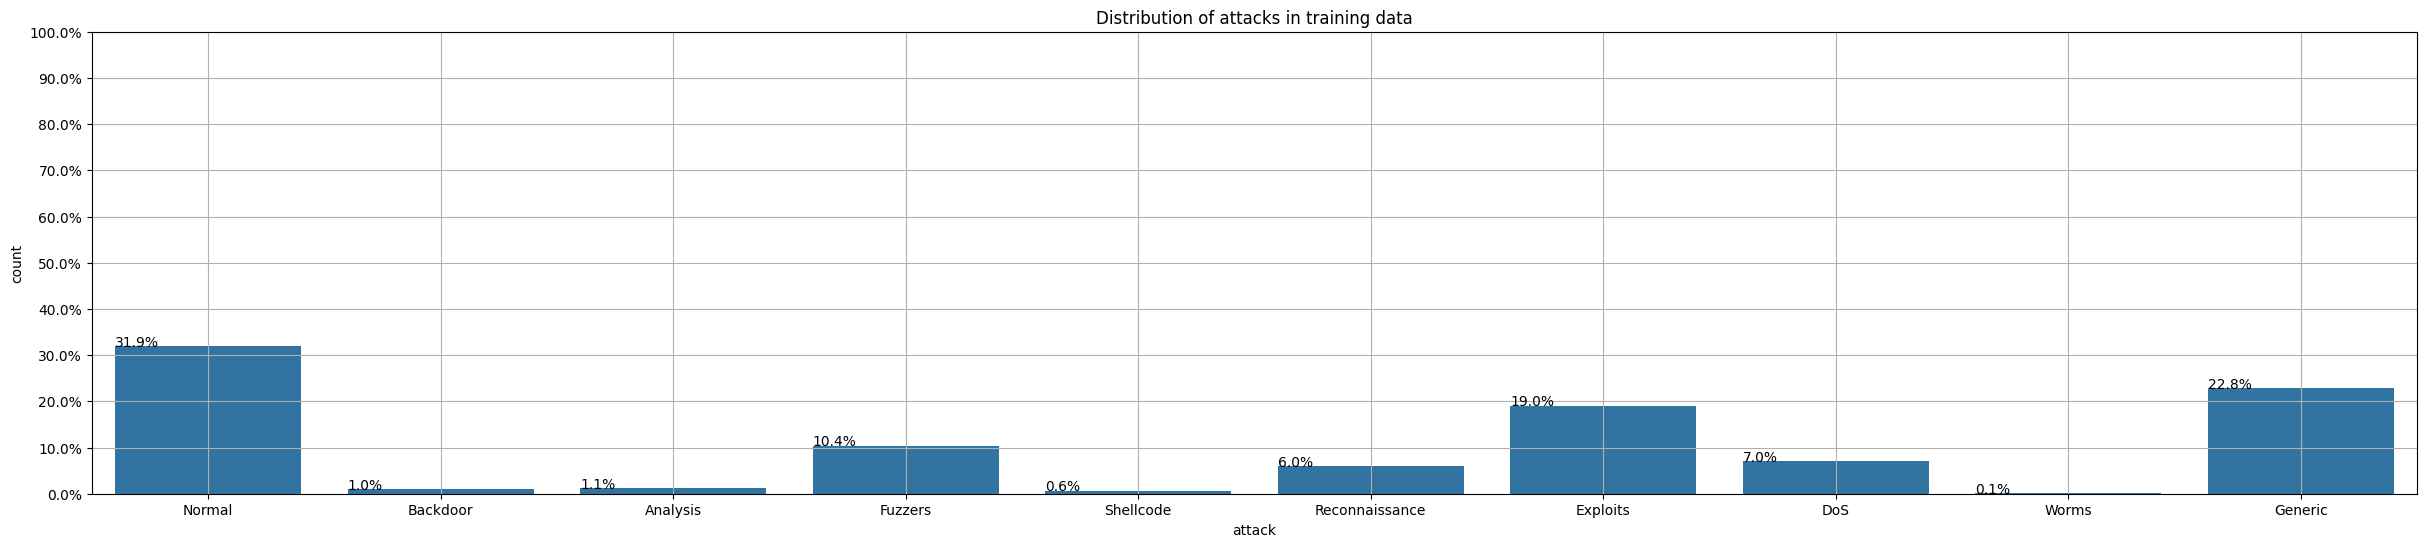

In [68]:
# Plot the distribution of all attacks in the train data
f, ax = plt.subplots(figsize=(30,6))
# Plot the data counts per attack (there are 23 attack classes)
ax = sns.countplot(x="attack", data=train_df)
# The total number of rows
total = len(train_df) * 1
# Plot bars for each attack
for p in ax.patches:
   ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x(), p.get_height()))
# Set axis ticks and thicklabels
ax.yaxis.set_ticks(np.linspace(0, total, 11))
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))

plt.title("Distribution of attacks in training data")
plt.grid()
plt.show()

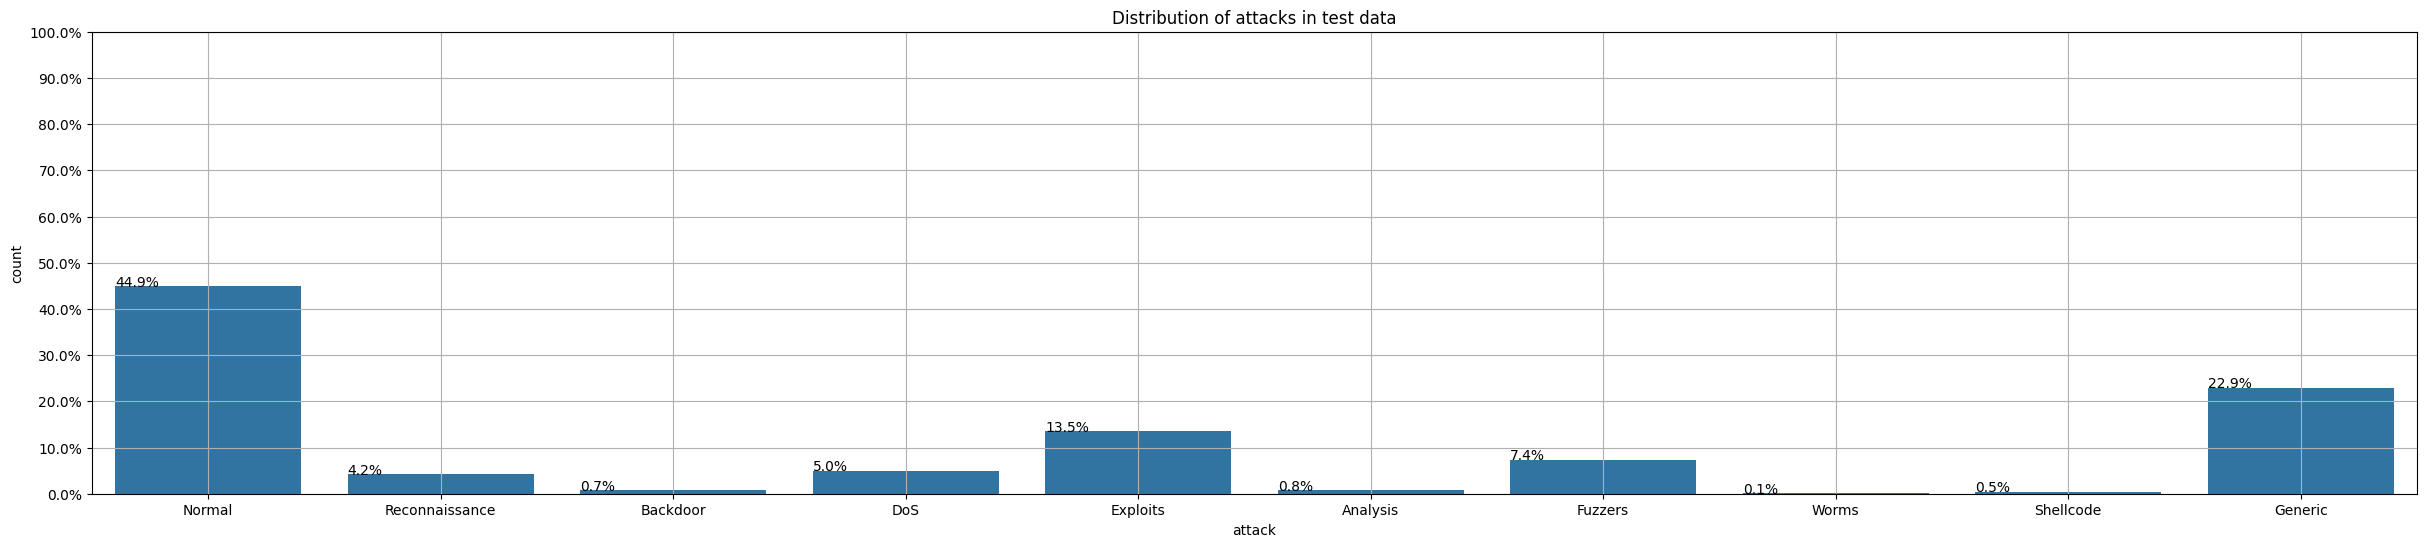

In [69]:
# And plot the distribution of all attacks in the test data
f, ax = plt.subplots(figsize=(30,6))
# Plot the data counts per attack (there are 23 attack classes)
ax = sns.countplot(x="attack", data=test_df)
# The total number of rows
total = len(test_df) * 1
# Plot bars for each attack
for p in ax.patches:
   ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x(), p.get_height()))
# Set axis ticks and thicklabels
ax.yaxis.set_ticks(np.linspace(0, total, 11))
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))

plt.title("Distribution of attacks in test data")
plt.grid()
plt.show()

In [70]:
# Print the sorted number of datapoints belonging to each attack class
train_class_distribution = train_df['attack'].value_counts()

# Sorting them in decreasing order (by number of datapoints)
sorted_yi = np.argsort(-train_class_distribution.values)
# Printing the number of datapoints and the percetange
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/len(train_df)*100), 3), '%)')

Number of data points in class 1 : 56000 ( 31.938 %)
Number of data points in class 2 : 40000 ( 22.813 %)
Number of data points in class 3 : 33393 ( 19.045 %)
Number of data points in class 4 : 18184 ( 10.371 %)
Number of data points in class 5 : 12264 ( 6.994 %)
Number of data points in class 6 : 10491 ( 5.983 %)
Number of data points in class 7 : 2000 ( 1.141 %)
Number of data points in class 8 : 1746 ( 0.996 %)
Number of data points in class 9 : 1133 ( 0.646 %)
Number of data points in class 10 : 130 ( 0.074 %)


In [71]:
# Repeat the same for the test data
test_class_distribution = test_df['attack'].value_counts()

# Sorting them in decreasing order (by number of datapoints)
sorted_yi = np.argsort(-test_class_distribution.values)
# Printing the number of datapoints and the percetange
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/len(test_df)*100), 3), '%)')

Number of data points in class 1 : 37000 ( 44.94 %)
Number of data points in class 2 : 18871 ( 22.921 %)
Number of data points in class 3 : 11132 ( 13.521 %)
Number of data points in class 4 : 6062 ( 7.363 %)
Number of data points in class 5 : 4089 ( 4.966 %)
Number of data points in class 6 : 3496 ( 4.246 %)
Number of data points in class 7 : 677 ( 0.822 %)
Number of data points in class 8 : 583 ( 0.708 %)
Number of data points in class 9 : 378 ( 0.459 %)
Number of data points in class 10 : 44 ( 0.053 %)


In [72]:
# The dataset have attacks that are present in the test set and not in the train set
# Print those attacks

trn = set(train_df['attack'].unique())
tst = set(test_df['attack'].unique())

extra = tst - trn

print(extra)
print("*"*100)
print("Number of extra attacks that are present only in the test set:", len(extra))

set()
****************************************************************************************************
Number of extra attacks that are present only in the test set: 0


## Data Loading Report

The dataset is mainly the attack data. In the training data it is only 32% normal data, while in the test data it is 45% normal data. The percentage of the data that is attacks is relatively similar between the two sets, with some loss due to there being more normal data in the test set.

# Convert categorical columns into numerical values

In [73]:
# Display the columns and the datatype for each column
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                175341 non-null  float64
 1   proto              175341 non-null  object 
 2   service            175341 non-null  object 
 3   state              175341 non-null  object 
 4   spkts              175341 non-null  int64  
 5   dpkts              175341 non-null  int64  
 6   sbytes             175341 non-null  int64  
 7   dbytes             175341 non-null  int64  
 8   rate               175341 non-null  float64
 9   sttl               175341 non-null  int64  
 10  dttl               175341 non-null  int64  
 11  sload              175341 non-null  float64
 12  dload              175341 non-null  float64
 13  sloss              175341 non-null  int64  
 14  dloss              175341 non-null  int64  
 15  sinpkt             175341 non-null  float64
 16  di

In [74]:
# Convert the columns with categorical values into numerical values
from sklearn.preprocessing import OrdinalEncoder

categs_feats = train_df[['proto', 'service', 'state', 'attack']]
encoder = OrdinalEncoder()
categs_encoded = encoder.fit_transform(categs_feats)

In [75]:
train_df[['proto', 'service', 'state', 'attack']] = pd.DataFrame(categs_encoded, columns=categs_feats.columns, index=categs_feats.index)
train_df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack,label
0,0.121478,113.0,0.0,2.0,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,6.0,0
1,0.649902,113.0,0.0,2.0,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,6.0,0
2,1.623129,113.0,0.0,2.0,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,6.0,0
3,1.681642,113.0,3.0,2.0,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,6.0,0
4,0.449454,113.0,0.0,2.0,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,6.0,0


In [76]:
# Create a training dataset
X_train = train_df.drop(['attack', 'label'], axis=1)
y_train = train_df['label']

In [77]:
# Repeat the same for the test dataset
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dur                82332 non-null  float64
 1   proto              82332 non-null  object 
 2   service            82332 non-null  object 
 3   state              82332 non-null  object 
 4   spkts              82332 non-null  int64  
 5   dpkts              82332 non-null  int64  
 6   sbytes             82332 non-null  int64  
 7   dbytes             82332 non-null  int64  
 8   rate               82332 non-null  float64
 9   sttl               82332 non-null  int64  
 10  dttl               82332 non-null  int64  
 11  sload              82332 non-null  float64
 12  dload              82332 non-null  float64
 13  sloss              82332 non-null  int64  
 14  dloss              82332 non-null  int64  
 15  sinpkt             82332 non-null  float64
 16  dinpkt             823

In [78]:
categs_feats = test_df[['proto', 'service', 'state', 'attack']]
encoder = OrdinalEncoder()
categs_encoded = encoder.fit_transform(categs_feats)

In [79]:
test_df[['proto', 'service', 'state', 'attack']] = pd.DataFrame(categs_encoded, columns=categs_feats.columns, index=categs_feats.index)
test_df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack,label
0,0.000011,117.0,0.0,4.0,2,0,496,0,90909.0902,254,...,1,2,0,0,0,1,2,0,6.0,0
1,0.000008,117.0,0.0,4.0,2,0,1762,0,125000.0003,254,...,1,2,0,0,0,1,2,0,6.0,0
2,0.000005,117.0,0.0,4.0,2,0,1068,0,200000.0051,254,...,1,3,0,0,0,1,3,0,6.0,0
3,0.000006,117.0,0.0,4.0,2,0,900,0,166666.6608,254,...,1,3,0,0,0,2,3,0,6.0,0
4,0.000010,117.0,0.0,4.0,2,0,2126,0,100000.0025,254,...,1,3,0,0,0,2,3,0,6.0,0


In [80]:
# Create a test dataset
X_test = test_df.drop(['attack', 'label'], axis=1)
y_test = test_df['label']

# Normalize the data values in each column to the range [0,1]

In [81]:
# Standardize features by scaling each feature to range [0, 1]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [82]:
# Note: the variables are now numpy arrays, and not pandas dataframes
print('Data type:', type(X_train))

# Display the shapes of train and test datasets
print('\nTrain shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

# Display the range to make sure they are in the [0, 1] range
print('\nMax value', np.max(X_train))
print('Min value', np.min(X_train))
print('Average value', np.mean(X_train))

Data type: <class 'numpy.ndarray'>

Train shape: (175341, 42)
Test shape: (82332, 42)

Max value 1.0000000000000002
Min value 0.0
Average value 0.11947813197204081


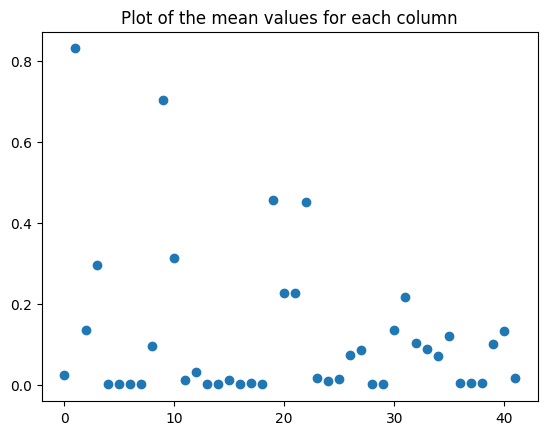

In [83]:
# Let's examine the mean values for each of the columns
plt.plot(np.mean(X_train, axis=0), 'o')
plt.title("Plot of the mean values for each column")
plt.show()

# Train Conventional ML Classifiers

In [84]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn.naive_bayes import GaussianNB

In [85]:
print('LOGISTIC REGRESSION')
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

print('Accuracy:', model_lr.score(X_test, y_test))

LOGISTIC REGRESSION
Accuracy: 0.7893650099596755


In [86]:
print('*** RANDOM FOREST ***')
model_rf = RandomForestClassifier(verbose=0, warm_start=True)
model_rf.fit(X_train, y_train)

print('Accuracy:', model_rf.score(X_test, y_test))

*** RANDOM FOREST ***
Accuracy: 0.8717631054753923


In [87]:
print('*** DECISION TREE ***')
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)

print('Accuracy:', model_dt.score(X_test, y_test))

*** DECISION TREE ***
Accuracy: 0.8584147111694117


In [88]:
print('*** K-NEAREST NEIGHBORS ***')
model_knn = KNeighborsClassifier(n_neighbors=3)
model_knn.fit(X_train, y_train)

print('Accuracy:', model_knn.score(X_test, y_test))

*** K-NEAREST NEIGHBORS ***
Accuracy: 0.8466452898022641


In [89]:
print('*** NAIVE BAYES ***')
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)

print('Accuracy:', model_nb.score(X_test, y_test))

*** NAIVE BAYES ***
Accuracy: 0.7429189136666181


In [90]:
print('*** SUPPORT VECTOR MACHINE ***')
model_svm = SVC()
model_svm.fit(X_train, y_train)

print('Accuracy:', model_svm.score(X_test, y_test))

*** SUPPORT VECTOR MACHINE ***
Accuracy: 0.8149443715687703


# Deep NN

In [91]:
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import datetime
now = datetime.datetime.now

In [92]:
# Define the layers for the network
input_seq = Input(shape=(42,))

hidden = Dense(1024, activation='relu')(input_seq)
hidden = Dropout(0.25)(hidden)
hidden = Dense(512, activation='relu')(hidden)
hidden = Dropout(0.25)(hidden)
hidden = Dense(256, activation='relu')(hidden)
hidden = Dropout(0.25)(hidden)
predictions = Dense(2, activation='softmax')(hidden)

# The model
model = Model(inputs=input_seq, outputs=predictions)

In [93]:
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Training time: 0:00:59.419110


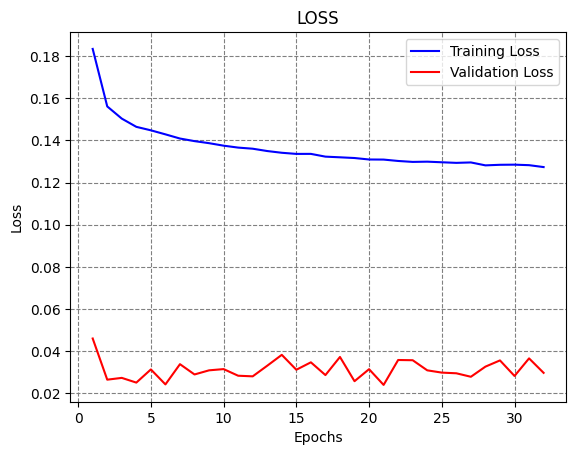

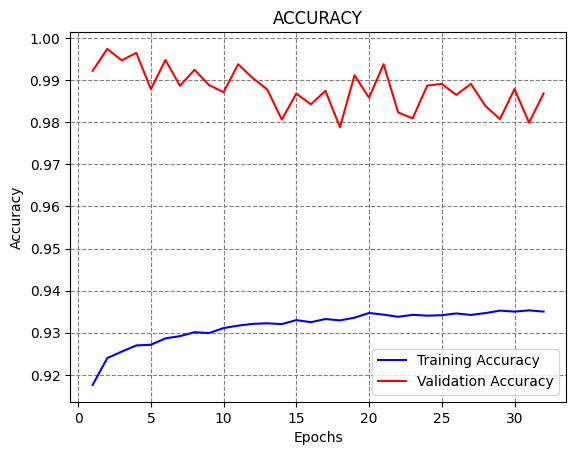

In [94]:
# Fit model
t = now()
callbacks = [EarlyStopping(monitor='val_accuracy', patience=30)]
history = model.fit(X_train, y_train, batch_size=256, epochs=300,
                     validation_split=0.2, verbose=0, callbacks=callbacks)

print('Training time: %s' % (now() - t))

# Plot the loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochsn = np.arange(1, len(train_loss)+1,1)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure()
plt.plot(epochsn, acc, 'b', label='Training Accuracy')
plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [95]:
# Evaluate on test data
evals_test = model.evaluate(X_test, y_test)
print("Classification Accuracy: ", evals_test[1])

2573/2573 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9526 - loss: 0.0943
Classification Accuracy:  0.87685227394104


## Models Report

The accuracy for the LR model was 78.94%, for the RF model it was 87.18%, for the DT model it was 85.84%, for the KNN model it was 84.66%, for the NB model it was 74.29%, for the SVC model it was 81.49%, and for the NN it was 87.69%. The accuracy of the LR and NB models were the lowest while the RF, DT, and KNN models were all similarly close the the NN model. The SVC model was in the middle accuracy-wise.

# Attacks

In [96]:
# Creating adversarial test sets of 1000 samples

# Define a random seed (to draw the same smamples)
np.random.seed(2)

ind = np.random.randint(1, 20000, 1000)

# Set of image for testing the attacks
adv_test_data = X_test[ind]
adv_test_labels = y_test[ind]

In [97]:
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod

In [98]:
classifier = TensorFlowV2Classifier(model=model, nb_classes=2,
                                    clip_values=(0, 1), input_shape=(42,), loss_object=tensorflow.keras.losses.SparseCategoricalCrossentropy())

In [99]:
# FGSM attack
epsilon = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8]

fgsm_attack_acc = []
for eps in epsilon:
    attack_fgsm = FastGradientMethod(estimator=classifier, eps=eps)
    fgsm_attack_adv_data = attack_fgsm.generate(adv_test_data)
    loss_test, accuracy_test = model.evaluate(fgsm_attack_adv_data, adv_test_labels)
    fgsm_attack_acc.append(accuracy_test)
    perturbation = np.mean(np.abs((fgsm_attack_adv_data - adv_test_data)))
    print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
    print('Average perturbation: {:4.2f}'.format(perturbation))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9732 - loss: 0.0915
Accuracy on adversarial test data: 96.40%
Average perturbation: 0.01
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9187 - loss: 0.2555
Accuracy on adversarial test data: 90.70%
Average perturbation: 0.02
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8501 - loss: 0.4029
Accuracy on adversarial test data: 84.70%
Average perturbation: 0.03
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8004 - loss: 0.7102
Accuracy on adversarial test data: 79.80%
Average perturbation: 0.06
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6481 - loss: 5.6909
Accuracy on adversarial test data: 65.80%
Average perturbation: 0.11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6086 - loss: 16.6750
Accuracy on adversarial test data: 61.40%
Average perturbation: 0.16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5639 - loss: 36.6743
Accuracy on adversarial test data: 57.50%
Average perturbation: 0.26
32/

In [100]:
# Create adversarail samples and display them
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.1)
fgsm_attack_adv_data = attack_fgsm.generate(adv_test_data)

np.set_printoptions(precision=2, suppress=True)
print("First test example:", adv_test_data[0])
print("\nFirst advesarial example:", fgsm_attack_adv_data[0])

First test example: [0.   0.89 0.   0.25 0.   0.   0.   0.   0.   1.   0.24 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.04 0.04
 0.   0.   0.02 0.   0.02 0.   0.   0.02 0.   0.   0.   0.02 0.02 0.  ]

First advesarial example: [0.   0.99 0.   0.35 0.   0.   0.   0.1  0.1  0.9  0.14 0.   0.1  0.
 0.1  0.1  0.   0.1  0.   0.1  0.1  0.1  0.1  0.   0.   0.   0.   0.14
 0.1  0.   0.12 0.   0.12 0.1  0.   0.   0.   0.1  0.   0.   0.12 0.1 ]


In [101]:
# Second adversarial sample
np.set_printoptions(precision=2, suppress=True)
print("Second test example:", adv_test_data[1])
print("\nSecond advesarial example:", fgsm_attack_adv_data[1])

Second test example: [0.   0.06 0.   0.5  0.   0.   0.   0.   0.33 1.   0.   0.04 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.04 0.
 0.   0.   0.15 0.33 0.18 0.18 0.2  0.14 0.   0.   0.   0.15 0.15 0.  ]

Second advesarial example: [0.   0.16 0.   0.6  0.   0.   0.   0.   0.43 1.   0.   0.   0.1  0.
 0.   0.   0.   0.   0.   0.1  0.1  0.1  0.1  0.   0.1  0.   0.   0.
 0.   0.   0.25 0.23 0.28 0.28 0.1  0.04 0.   0.   0.   0.05 0.05 0.1 ]


### JSMA

In [102]:
from art.attacks.evasion import SaliencyMapMethod

In [103]:
jsma_attack = SaliencyMapMethod(
    classifier=classifier,
    theta=1.0,
    gamma=0.1,
    batch_size=1,
    verbose=True
)
jsma_attack_adv_data = jsma_attack.generate(adv_test_data)
loss_test, accuracy_test = model.evaluate(jsma_attack_adv_data, adv_test_labels)
fgsm_attack_acc.append(accuracy_test)
perturbation = np.mean(np.abs((jsma_attack_adv_data - adv_test_data)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))
jsma_attack = SaliencyMapMethod(
    classifier=classifier,
    theta=-1.0,
    gamma=0.1,
    batch_size=1,
    verbose=True
)
jsma_attack_adv_data = jsma_attack.generate(adv_test_data)
loss_test, accuracy_test = model.evaluate(jsma_attack_adv_data, adv_test_labels)
fgsm_attack_acc.append(accuracy_test)
perturbation = np.mean(np.abs((jsma_attack_adv_data - adv_test_data)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))
jsma_attack = SaliencyMapMethod(
    classifier=classifier,
    theta=1.0,
    gamma=0.01,
    batch_size=1,
    verbose=True
)
jsma_attack_adv_data = jsma_attack.generate(adv_test_data)
loss_test, accuracy_test = model.evaluate(jsma_attack_adv_data, adv_test_labels)
fgsm_attack_acc.append(accuracy_test)
perturbation = np.mean(np.abs((jsma_attack_adv_data - adv_test_data)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

JSMA:   0%|          | 0/1000 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0569 - loss: 18.5926
Accuracy on adversarial test data: 6.30%
Average perturbation: 0.07


JSMA:   0%|          | 0/1000 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5433 - loss: 2.9900
Accuracy on adversarial test data: 54.70%
Average perturbation: 0.02


JSMA:   0%|          | 0/1000 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6125 - loss: 4.3612
Accuracy on adversarial test data: 60.50%
Average perturbation: 0.04


In [104]:
# Create adversarail samples and display them
attack_jsma = jsma_attack = SaliencyMapMethod(
    classifier=classifier,
    theta=1.0,
    gamma=0.1,
    batch_size=1,
    verbose=True
)
jsma_attack_adv_data = attack_jsma.generate(adv_test_data)

np.set_printoptions(precision=2, suppress=True)
print("First test example:", adv_test_data[0])
print("\nFirst advesarial example:", jsma_attack_adv_data[0])

JSMA:   0%|          | 0/1000 [00:00<?, ?it/s]

First test example: [0.   0.89 0.   0.25 0.   0.   0.   0.   0.   1.   0.24 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.04 0.04
 0.   0.   0.02 0.   0.02 0.   0.   0.02 0.   0.   0.   0.02 0.02 0.  ]

First advesarial example: [0.   0.89 0.   0.25 0.   0.   0.   0.   0.   1.   0.24 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.04 0.04
 0.   0.   1.   0.   0.02 1.   0.   0.02 0.   0.   0.   0.02 0.02 0.  ]


In [105]:
# Second adversarial sample
np.set_printoptions(precision=2, suppress=True)
print("Second test example:", adv_test_data[1])
print("\nSecond advesarial example:", jsma_attack_adv_data[1])

Second test example: [0.   0.06 0.   0.5  0.   0.   0.   0.   0.33 1.   0.   0.04 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.04 0.
 0.   0.   0.15 0.33 0.18 0.18 0.2  0.14 0.   0.   0.   0.15 0.15 0.  ]

Second advesarial example: [0.   0.06 0.   0.5  0.   0.   0.   0.   0.33 1.   0.   0.04 0.   0.
 0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.04 0.
 0.   0.   0.15 0.33 0.18 1.   0.2  0.14 0.   0.   0.   0.15 0.15 0.  ]


### FGSM against LR model

In [106]:
from art.estimators.classification import SklearnClassifier

In [107]:
classifier_lr = SklearnClassifier(model=model_lr)

In [108]:
fgsm_attack_acc = []
for eps in epsilon:
    attack_fgsm = FastGradientMethod(estimator=classifier_lr, eps=eps)
    fgsm_attack_adv_data = attack_fgsm.generate(adv_test_data)
    loss_test, accuracy_test = model.evaluate(fgsm_attack_adv_data, adv_test_labels)
    fgsm_attack_acc.append(accuracy_test)
    perturbation = np.mean(np.abs((fgsm_attack_adv_data - adv_test_data)))
    print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
    print('Average perturbation: {:4.2f}'.format(perturbation))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9776 - loss: 0.0535
Accuracy on adversarial test data: 97.60%
Average perturbation: 0.01
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9064 - loss: 0.2494
Accuracy on adversarial test data: 90.80%
Average perturbation: 0.02
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8464 - loss: 0.7764
Accuracy on adversarial test data: 85.50%
Average perturbation: 0.05
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2402 - loss: 4.7546
Accuracy on adversarial test data: 24.50%
Average perturbation: 0.10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0118 - loss: 48.0919
Accuracy on adversarial test data: 1.00%
Average perturbation: 0.20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0118 - loss: 144.6020
Accuracy on adversarial test data: 1.00%
Average perturbation: 0.30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0118 - loss: 407.9594
Accuracy on adversarial test data: 1.00%
Average perturbation: 0.50
32/3

In [109]:
# Create adversarail samples and display them
attack_fgsm = FastGradientMethod(estimator=classifier_lr, eps=0.1)
fgsm_attack_adv_data = attack_fgsm.generate(adv_test_data)

np.set_printoptions(precision=2, suppress=True)
print("First test example:", adv_test_data[0])
print("\nFirst advesarial example:", fgsm_attack_adv_data[0])

First test example: [0.   0.89 0.   0.25 0.   0.   0.   0.   0.   1.   0.24 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.04 0.04
 0.   0.   0.02 0.   0.02 0.   0.   0.02 0.   0.   0.   0.02 0.02 0.  ]

First advesarial example: [-0.1   0.99 -0.1   0.15 -0.1  -0.1  -0.1   0.1  -0.1   0.9   0.14  0.1
  0.1  -0.1   0.1   0.1   0.1   0.1  -0.1   0.1   0.1  -0.1   0.1   0.1
  0.1  -0.1   0.14 -0.06  0.1   0.1   0.12 -0.1  -0.08 -0.1  -0.1  -0.08
 -0.1  -0.1   0.1  -0.08  0.12  0.1 ]


In [110]:
# Second adversarial sample
np.set_printoptions(precision=2, suppress=True)
print("Second test example:", adv_test_data[1])
print("\nSecond advesarial example:", fgsm_attack_adv_data[1])

Second test example: [0.   0.06 0.   0.5  0.   0.   0.   0.   0.33 1.   0.   0.04 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.04 0.
 0.   0.   0.15 0.33 0.18 0.18 0.2  0.14 0.   0.   0.   0.15 0.15 0.  ]

Second advesarial example: [-0.1   0.16 -0.1   0.4  -0.1  -0.1  -0.1   0.1   0.23  0.9  -0.1   0.14
  0.1  -0.1   0.1   0.1   0.1   0.1  -0.1   0.1   0.1  -0.1   0.1   0.1
  0.1  -0.1   0.14 -0.1   0.1   0.1   0.25  0.23  0.08  0.08  0.1   0.04
 -0.1  -0.1   0.1   0.05  0.25  0.1 ]


## Attacks Report

The accuracy against the FGSM attack on the deep learning model was 54.70%, against the JSMA it was 60.50%, and against the FGSM attack on the linear regression model it was 1.00%. Due to the deep learning model being complex and having non-linear decision boundaries the FGSM attack against it was succesful, but the model still showed some success. Since the JSMA is more targeted and precise, meaning less destructive, it resulted in a worse showing than the FGSM attack. The FGSM attack on the linear regression model was so succesful because the model has simple linear decision boundaries, which this specific attack are especially good at targetting.